# Multi-Step Machine Learning Approach
In this file, we build a model with multiple steps. This multi-tiered approach allows us to tackle the problem from a macro (city-wide) level and then drill down to micro factors influencing individual or grouped shelter demands.


I am thinking we should use SARIMA for the the initial model (just predicting the overall shelter demand). Then, we can create regression models for each subgroup (e.g., postal code, organization) that predict the deviation from the city-wide average based on historical data.

## Imports

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

## Data

### Shelter Data

In [ ]:
shelter_paths = ['/content/drive/MyDrive/Colab Notebooks/Borealis Project/daily-shelter-overnight-service-occupancy-capacity-2021.csv', '/content/drive/MyDrive/Colab Notebooks/Borealis Project/daily-shelter-overnight-service-occupancy-capacity-2022.csv', '/content/drive/MyDrive/Colab Notebooks/Borealis Project/daily-shelter-overnight-service-occupancy-capacity-2023.csv']

dataframes = [pd.read_csv(file) for file in shelter_paths]

# Load each file and verify its contents
for file in shelter_paths:
    try:
        df = pd.read_csv(file)
        if df.empty:
            print(f"The file at {file} is empty.")
        else:
            print(f"Loaded {len(df)} rows from {file}")
            dataframes.append(df)
    except FileNotFoundError:
        print(f"No file found at {file}")
    except pd.errors.EmptyDataError:
        print(f"File at {file} is empty or corrupted.")

# If all DataFrames are loaded correctly, concatenate them into one
if dataframes:
    combined_df = pd.concat(dataframes, ignore_index=True)
    print(f"The combined dataframe has {len(combined_df)} rows.")
else:
    print("No data has been loaded. Please check the file paths and contents.")

Loaded 50944 rows from /content/drive/MyDrive/Colab Notebooks/Borealis Project/daily-shelter-overnight-service-occupancy-capacity-2021.csv
Loaded 49478 rows from /content/drive/MyDrive/Colab Notebooks/Borealis Project/daily-shelter-overnight-service-occupancy-capacity-2022.csv
Loaded 48345 rows from /content/drive/MyDrive/Colab Notebooks/Borealis Project/daily-shelter-overnight-service-occupancy-capacity-2023.csv
The combined dataframe has 297534 rows.


## SARIMA Modelling

**Background**

SARIMA stands for Seasonal AutoRegressive Integrated Moving Average. It is an extension of ARIMA that supports univariate time series data with a seasonal component. he model is specified with the notations SARIMA(p, d, q)(P, D, Q)m, where:

    * p: Order of the autoregressive part.
    * d: Degree of first differencing involved.
    * q: Order of the moving average part.
    * P: Seasonal autoregressive order.
    * D: Seasonal difference order.
    * Q: Seasonal moving average order.
    * m: The number of time steps for a single seasonal period.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

### Data Preparation

In [ ]:
combined_df = combined_df.dropna(subset=['CAPACITY_TYPE'])

combined_total_df = combined_df
combined_total_df['OCCUPANCY_RATE'] = np.where(combined_df['OCCUPANCY_RATE_BEDS'].isna(),
                                       combined_df['OCCUPANCY_RATE_ROOMS'],
                                       combined_df['OCCUPANCY_RATE_BEDS'])

In [ ]:
# Extract year, month, and day as separate features
combined_total_df['OCCUPANCY_DATE'] = pd.to_datetime(combined_total_df['OCCUPANCY_DATE'],format='mixed')
combined_total_df['YEAR'] = combined_total_df['OCCUPANCY_DATE'].dt.year
combined_total_df['MONTH'] = combined_total_df['OCCUPANCY_DATE'].dt.month
combined_total_df['DAY'] = combined_total_df['OCCUPANCY_DATE'].dt.day

In [ ]:
daily_city_average = combined_total_df.groupby('OCCUPANCY_DATE')['OCCUPANCY_RATE'].mean().reset_index()
print(daily_city_average.head())

  OCCUPANCY_DATE  OCCUPANCY_RATE
0     2021-01-01       93.056809
1     2021-01-02       93.206667
2     2021-01-03       92.847589
3     2021-01-04       92.394965
4     2021-01-05       92.289859


### Model

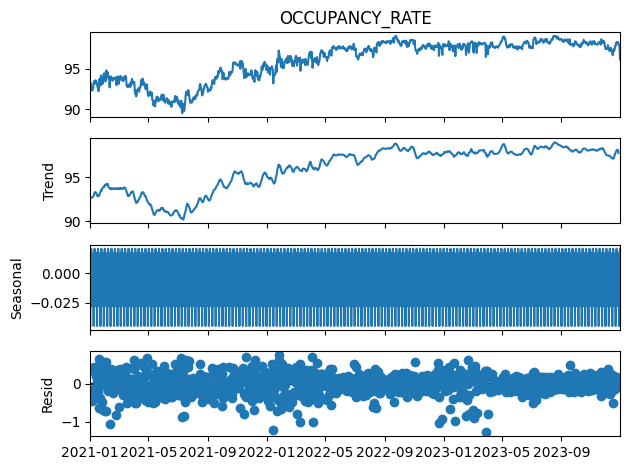

In [ ]:
daily_city_average.set_index('OCCUPANCY_DATE', inplace=True)
daily_city_average.index = pd.to_datetime(daily_city_average.index)

y = daily_city_average['OCCUPANCY_RATE'] # Target Variable: OCCUPANCY RATE

decomposition = seasonal_decompose(y, model='additive')
decomposition.plot()
plt.show()

In [ ]:
# Finding The Best Parameters
# found the following method online

!pip install pmdarima
from pmdarima import auto_arima

# Auto ARIMA model
y = daily_city_average['OCCUPANCY_RATE']
auto_arima_model = auto_arima(y, start_p=0, start_q=0,
                              test='adf',       # Use adftest to find optimal 'd'
                              max_p=3, max_q=3, # Maximum p and q
                              m=12,              # Frequency of the series
                              d=None,           # Let model determine 'd'
                              seasonal=True,   # No Seasonality
                              start_P=0,
                              D=1,
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=True)

print(auto_arima_model.summary())

# TAKES A REALLY LONG TIME TO RUN
# RESULTS FROM INITIAL RUN:
#     p, d, q = 3, 0, 1
#     P, D, Q, m = 2, 1, 0, 12

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=2254.257, Time=3.13 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2409.754, Time=0.63 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1244.008, Time=6.86 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1625.124, Time=3.15 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2413.601, Time=0.12 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1483.146, Time=0.50 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1138.657, Time=5.82 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=26.04 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=12.49 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=2242.119, Time=3.25 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1122.891, Time=10.24 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1233.421, Time=3.75 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=29.44 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=14.72 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept

In [ ]:
# applying parameters to SARIMA
p, d, q = 3, 0, 0
P, D, Q, m = 2, 1, 0, 12

city_model = SARIMAX(y,
                order=(p, d, q),
                seasonal_order=(P, D, Q, m),
                enforce_stationarity=False,
                enforce_invertibility=False)

city_results = city_model.fit()

# Summary of the model
print(city_results.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                     OCCUPANCY_RATE   No. Observations:                 1095
Model:             SARIMAX(3, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -510.568
Date:                            Sun, 14 Apr 2024   AIC                           1033.136
Time:                                    17:59:08   BIC                           1062.909
Sample:                                01-01-2021   HQIC                          1044.422
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7065      0.024     29.200      0.000       0.659       0.754
ar.L2          0.0553      0.034   

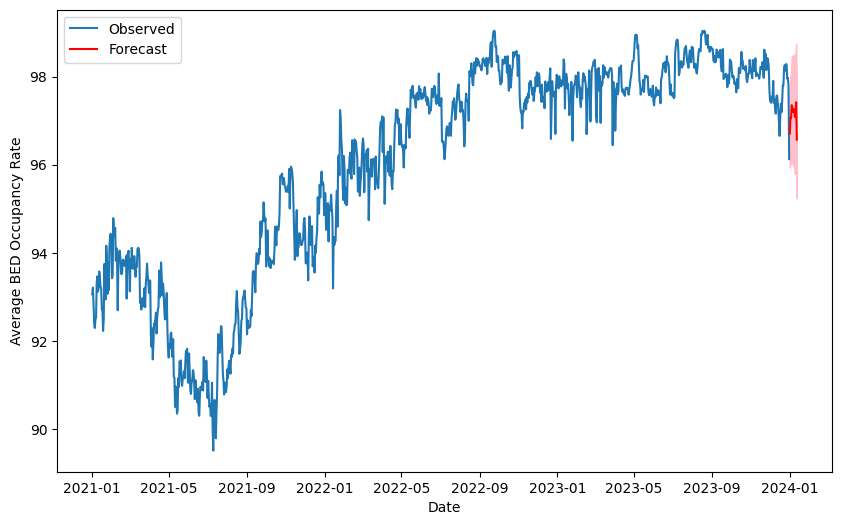

In [ ]:
# City Forecast
city_forecast = city_results.get_forecast(steps=12)
city_mean_forecast = city_forecast.predicted_mean
city_conf_int = city_forecast.conf_int()

# Plot the forecast including the confidence intervals
plt.figure(figsize=(10, 6))
plt.plot(y.index, y, label='Observed')
plt.plot(city_mean_forecast.index, city_mean_forecast, color='red', label='Forecast')
plt.fill_between(city_conf_int.index, city_conf_int.iloc[:, 0], city_conf_int.iloc[:, 1], color='pink')
plt.xlabel('Date')
plt.ylabel('Average BED Occupancy Rate')
plt.legend()
plt.show()

### Training and Testing

In [ ]:
split_point = int(len(y) * 0.8)
city_y_train, city_y_test = y.iloc[:split_point], y.iloc[split_point:]



city_model_train = SARIMAX(city_y_train,
                                 order=(p, d, q),
                                 seasonal_order=(P, D, Q, m),
                                 enforce_stationarity=False,
                                 enforce_invertibility=False)
city_training_results = city_model_train.fit()

# Forecast
city_forecast_training = city_training_results.get_forecast(steps=len(city_y_test))
city_predictions_training = city_forecast_training.predicted_mean

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Metrics without weather data
mae_city = mean_absolute_error(city_y_test, city_predictions_training)
mse_city = mean_squared_error(city_y_test, city_predictions_training)
rmse_city = np.sqrt(mse_city)
mape_city = mean_absolute_percentage_error(city_y_test, city_predictions_training)

# Print the metrics to compare
print(f"MAE: {mae_city}, MSE: {mse_city}, RMSE: {rmse_city}, MAPE: {mape_city}%")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 0.42491919424562674, MSE: 0.26320616134808406, RMSE: 0.513036218358981, MAPE: 0.4327077496079315%


## Regression Models

### Postal Code

### Shelter T